In [1]:
###HOMEWORK 5###
"""
Program that will create a class function called MassProfile
Assignment is to determine the mass distrubition of each galaxy at some SnapNumber = 0,
which will be used to determine galaxy's rotation curve.

Using files MW, M31,and M33_000.txt
"""

"\nProgram that will create a class function called MassProfile\nAssignment is to determine the mass distrubition of each galaxy at some SnapNumber = 0,\nwhich will be used to determine galaxy's rotation curve.\n"

In [164]:
"""Import Packages"""
import numpy as np
import astropy.units as u
from astropy.constants import G
import matplotlib.pyplot as plt
"""Import Modules"""
from Readfile import Read
from CenterOfMass import CenterOfMass

%matplotlib inline

In [170]:
# Make class function
class MassProfile:
    
    # Function that takes inputs: object(self), a galaxy name, snapshot number
    def __init__(self, Galaxy, Snap):
            
            # Add a string of the filenumber to the value '000'
            ilbl = '000' + str(Snap)
            # Remove all but last 3 digitis
            ilbl = ilbl[-3:]
            self.filename = '%s_' % (Galaxy) + ilbl #+ '.txt'
            
            # Read input filename and store time, total, and data of file
            self.time, self.total, self.data = Read(self.filename)
            
            # Store position coordinates with appropiate units
            self.x = self.data['x']*u.kpc
            self.y = self.data['y']*u.kpc
            self.z = self.data['z']*u.kpc
            
            # Store mass of data w/o units for now
            self.m = self.data['m']
            
            # Store name of galaxy as global property
            self.gname = Galaxy
            
            self.G = G.to(u.kpc*u.km**2/u.s**2/u.M_sun)
            """End of Initializer"""
            
            
    def MassEnclosed(self, ptype, radii):
        # Function that takes in inputs: particle type array of radii
        # Function returns array of masses in solar mass (M_sun)
        
        p_index = np.where(self.data['type'] == ptype) 
        #print(p_index)
        x = self.data['x'][p_index]
        y = self.data['y'][p_index]
        z = self.data['z'][p_index]
        #print(x)
        m = self.data['m'][p_index]
        #print(m)
        # Make center of mass object
        COM_Object = CenterOfMass(self.filename, ptype)
        
        
        # Call COM object to determine center of mass
        XCOM, YCOM, ZCOM = COM_Object.COM_P(10)
        
        # Convert to rotating frame
        XNEW = x - XCOM
        YNEW = y - YCOM
        ZNEW = z - ZCOM
        
        # Find R value
        R = np.sqrt(XNEW**2 + YNEW**2 + ZNEW**2)
        #print(XCOM)
        
        # Set Empty array of length == radius length
        M_enclosed = np.zeros(len(radii))
        
        # Loop that calculates mass enclosed in regain
        for r in range(len(radii)):
            
            # Find all indicies less than or equal to radius array values
            index = np.where(R <= radii[r])
            
            # Sum all masses in region
            M_at_r = np.sum(m[index])*1e10
            
            # Add values to empty array
            M_enclosed[r] = M_at_r
     
        # Return the array
        return M_enclosed
            
            
    def TotalMassEnclosed(self, radii):
        # Function that takes in inputs: radii
        # Function returns array of masses at each radii
        if  self.gname != 'M33':
            M_Bulge = self.MassEnclosed(3,radii)
            M_Disk = self.MassEnclosed(2,radii)
            M_Halo = self.MassEnclosed(1,radii)
            Total_Mass = (M_Bulge + M_Disk + M_Halo)
        else:
            M_Disk = self.MassEnclosed(2,radii)
            M_Halo = self.MassEnclosed(1,radii)
            Total_Mass = (M_Disk + M_Halo)
        return Total_Mass
        """End of TotalMassEnclosed funciton"""
        
        
        
    def HernquistMass(self, radii, a, M_halo):
        # Function that computes a theoretical profile of mass enclosed
        # Function takes in inputs, radius, scale factor a, and halo mass M_halo
        # Function returns Hernquist Mass of theo. pro. in mass units of M_sun
    
        # Define Hernquirst Mass function
        # Define numerator and denominator
        numer = M_halo*radii**2
        denom = (a+radii)**2
        
        # Evaluate Hernquirst Mass function
        HM_r = numer/denom
        
        # HM with units
        Hernquist_Mass = HM_r*u.M_sun
        return Hernquist_Mass
        """End of Hernquist Mass funciton """
        
        
    def CircularVelocity(self, ptype, radii):
        # Function that takes inputs: particle type, and array of radii
        # Funcitn returns circular velocity in km/s rounded to two decimal places
        
        # Constants w/ proper conversions
        #G = G.to(u.kpc*u.km**2/u.s**2/u.M_sun)
        
        #Redefine paramerters to shorten equation
        Mass = self.MassEnclosed(ptype,radii)*u.Msun
        Radius = radii*u.kpc
        
        # Cir. Speed is computed using the Mass enclosed at each radius, assume spherical symmemtry
        V_circ = np.sqrt(G*Mass/Radius)
        
        # return V_circ
        return V_circ
        """End of Circular Velocity Funciton"""
        
        
    def TotalCircularVelocity(self, radii):
        # Function that takes inputs: array of radii
        # Function returns array of Circular velcoity w/ units km/s which represents
        # total V_circ created by all Gal, components (bulge+disk+halo)

        #G = G.to(u.kpc*u.km**2/u.s**2/u.M_sun)
        
        
        #Redefine parameters for equation
        Mass_tot = self.TotalMassEnclosed(radii)*u.Msun
        Radius = radii*u.kpc
        
        # Calculate Total Velocity
        Total_Velocity = np.sqrt(self.G*Mass_tot/Radius)
       
        #return Total velocity
        return Total_Velocity            
    
    def HernquistVCirc(self, radii, a, M_halo):
        # Function that takes inputs: HM profile, and array of radii
        # Function returns Hernquist Circular Velocity in units of km/s to the two decimals places
        # Easier to just call the funciton 
        
        # Constants w/ proper conversions
        #G = G.to(u.kpc*u.km**2/u.s**2/u.M_sun)
        
        # Redefine Parameters for equation
        Mass_H = self.HernquistMass(radii, a, M_halo)*u.Msun
        Radius = radii * u.kpc
        
        # Calculate hern velocity
        HV_circ = np.sqrt(self.G*Mass_H/Radius)
        
        #return Hern velocity
        return HV_circ
    

In [144]:
R_array = np.arange(0.01,30, 0.1)
#MP = MassProfile('MW',0)
#M_en = MP.MassEnclosed(1, R_array)
#print (R_array)

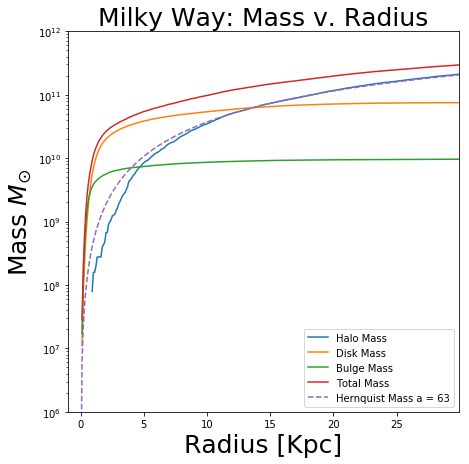

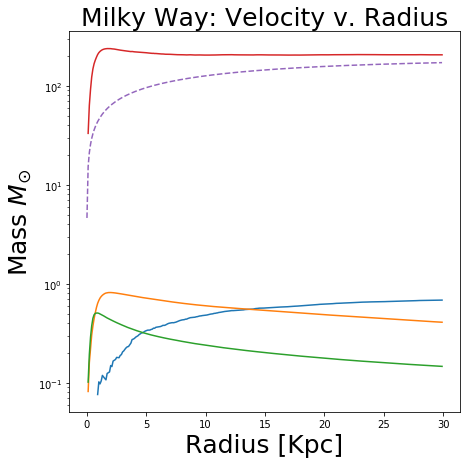

In [175]:
### Componenet Mass enclosed
MW = MassProfile('MW',0)
M31 = MassProfile('M31',0)
M33 = MassProfile('M33',0)

M_HALO_MW = CenterOfMass('MW_000',1).total_mass()
M_HALO_M31 = CenterOfMass('M31_000',1).total_mass()
M_HALO_M33 = CenterOfMass('M33_000',1).total_mass()


MW_M_Halo = MW.MassEnclosed(1,R_array)
MW_M_Disk = MW.MassEnclosed(2,R_array)
MW_M_Bulge = MW.MassEnclosed(3,R_array)
MW_V_Halo = MW.CircularVelocity(1,R_array)
MW_V_Disk = MW.CircularVelocity(2,R_array)
MW_V_Bulge = MW.CircularVelocity(3,R_array)

MW_M_Total = MW.TotalMassEnclosed(R_array)
MW_V_Total = MW.TotalCircularVelocity(R_array)
MW_M_Hernq = MW.HernquistMass(R_array, 63, M_HALO_MW)
MW_V_Hernq = MW.HernquistVCirc(R_array, 63, M_HALO_MW)


plt.figure(figsize=([7,7]))
plt.title("Milky Way: Mass v. Radius", fontsize = 25)
plt.xlabel("Radius [Kpc]", fontsize = 25)
plt.ylabel("Mass $M_{\odot}$", fontsize = 25)
plt.axis([-1,R_array[-1],1e6,1e12])
plt.semilogy(R_array, MW_M_Halo, '-', label = "Halo Mass")
plt.semilogy(R_array, MW_M_Disk, label = "Disk Mass")
plt.semilogy(R_array, MW_M_Bulge, label = "Bulge Mass")
plt.semilogy(R_array, MW_M_Total, label = "Total Mass")
plt.semilogy(R_array, MW_M_Hernq, '--', label = "Hernquist Mass a = 63")
plt.legend()

plt.figure(figsize=([7,7]))
plt.title("Milky Way: Velocity v. Radius", fontsize = 25)
plt.xlabel("Radius [Kpc]", fontsize = 25)
plt.ylabel("Mass $M_{\odot}$", fontsize = 25)
#plt.axis([-1,R_array[-1],1e6,1e12])
plt.semilogy(R_array, MW_V_Halo, '-', label = "Halo Mass")
plt.semilogy(R_array, MW_V_Disk, label = "Disk Mass")
plt.semilogy(R_array, MW_V_Bulge, label = "Bulge Mass")
plt.semilogy(R_array, MW_V_Total, label = "Total Mass")
plt.semilogy(R_array, MW_V_Hernq, '--', label = "Hernquist Mass a = 63")
plt.legend()


In [185]:


"""Mass and Velocity of M31"""
M31_M_Halo = M31.MassEnclosed(1,R_array)
M31_M_Disk = M31.MassEnclosed(2,R_array)
M31_M_Bulge = M31.MassEnclosed(3,R_array)
M31_M_Total = M31.TotalMassEnclosed(R_array)
M31_M_Hernq = M31.HernquistMass(R_array, 63, M_HALO)

M31_V_Halo = M31.CircularVelocity(1,R_array)
M31_V_Disk = M31.CircularVelocity(2,R_array)
M31_V_Bulge = M31.CircularVelocity(3,R_array)
M31_V_Total = M31.TotalCircularVelocity(R_array)
M31_V_Hernq = M31.HernquistVCirc(R_array, 63, M_HALO_M31)


"""Mass and Velocity M33"""
M33_M_Halo = M33.MassEnclosed(1,R_array)
M33_M_Disk = M33.MassEnclosed(2,R_array)
M33_M_Total = M33.TotalMassEnclosed(R_array)
M33_M_Hernq = M33.HernquistVCirc(R_array, 63, M_HALO_M33)

M33_V_Halo = M33.CircularVelocity(1,R_array)
M33_V_Disk = M33.CircularVelocity(2,R_array)
M33_V_Total = M33.TotalCircularVelocity(R_array)
M33_V_Hernq = M33.HernquistVCirc(R_array, 63, M_HALO_M33)







In [187]:
M31_M_Hernq = M31.HernquistMass(R_array, 63, M_HALO)
M33_M_Hernq = M33.HernquistMass(R_array, 25, M_HALO)


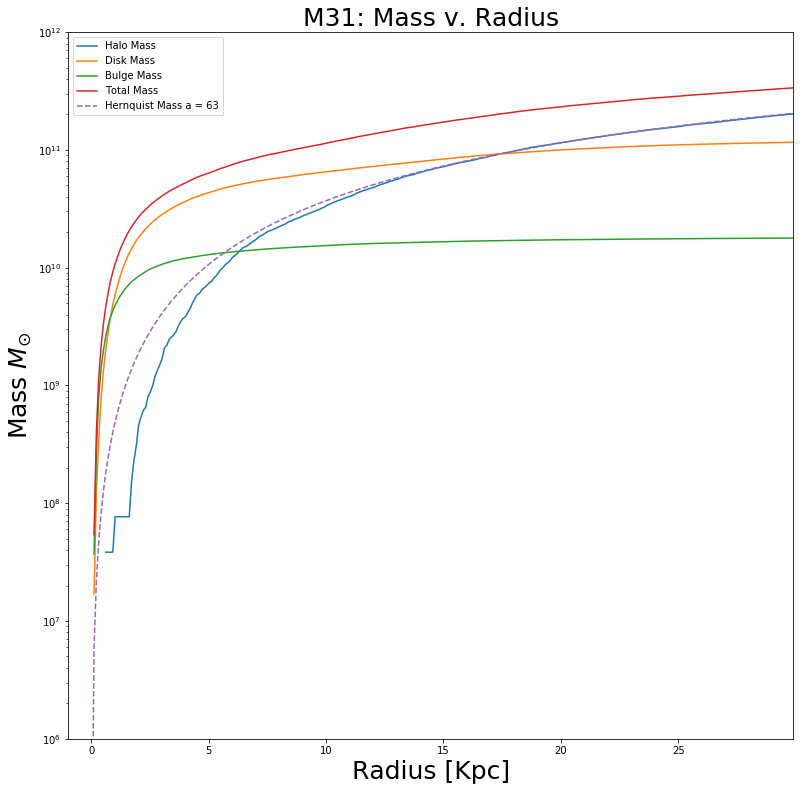

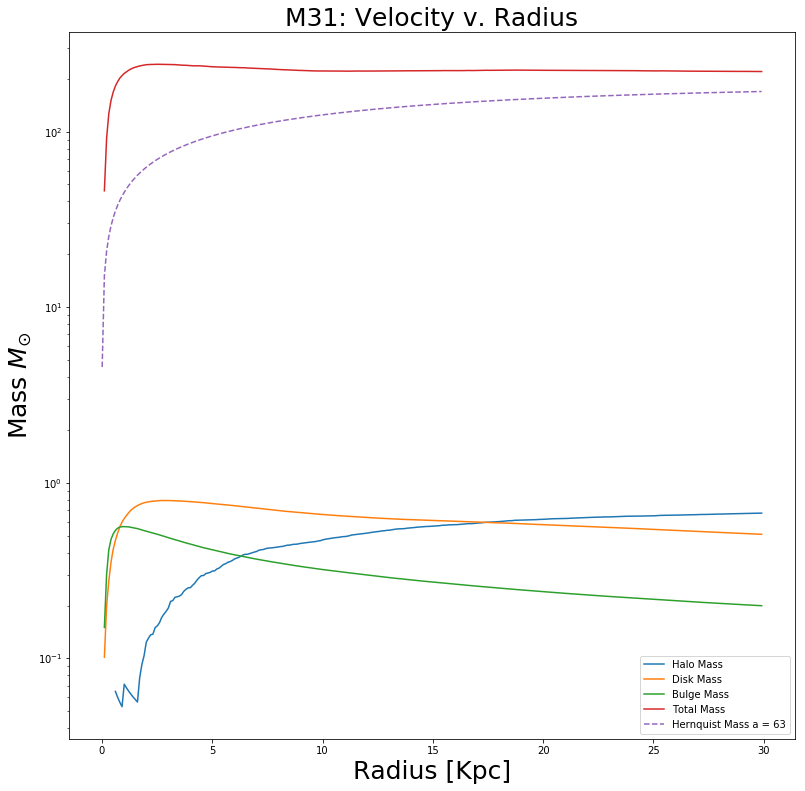

In [191]:
"""Plotting M31"""

plt.figure(figsize=([13,13]))
plt.title("M31: Mass v. Radius", fontsize = 25)
plt.xlabel("Radius [Kpc]", fontsize = 25)
plt.ylabel("Mass $M_{\odot}$", fontsize = 25)
plt.axis([-1,R_array[-1],1e6,1e12])
plt.semilogy(R_array, M31_M_Halo, '-', label = "Halo Mass")
plt.semilogy(R_array, M31_M_Disk, label = "Disk Mass")
plt.semilogy(R_array, M31_M_Bulge, label = "Bulge Mass")
plt.semilogy(R_array, M31_M_Total, label = "Total Mass")
plt.semilogy(R_array, M31_M_Hernq, '--', label = "Hernquist Mass a = 63")
plt.legend()

plt.figure(figsize=([13,13]))
plt.title("M31: Velocity v. Radius", fontsize = 25)
plt.xlabel("Radius [Kpc]", fontsize = 25)
plt.ylabel("Mass $M_{\odot}$", fontsize = 25)
#plt.axis([-1,R_array[-1],1e6,1e12])
plt.semilogy(R_array, M31_V_Halo, '-', label = "Halo Mass")
plt.semilogy(R_array, M31_V_Disk, label = "Disk Mass")
plt.semilogy(R_array, M31_V_Bulge, label = "Bulge Mass")
plt.semilogy(R_array, M31_V_Total, label = "Total Mass")
plt.semilogy(R_array, M31_V_Hernq, '--', label = "Hernquist Mass a = 63")
plt.legend()


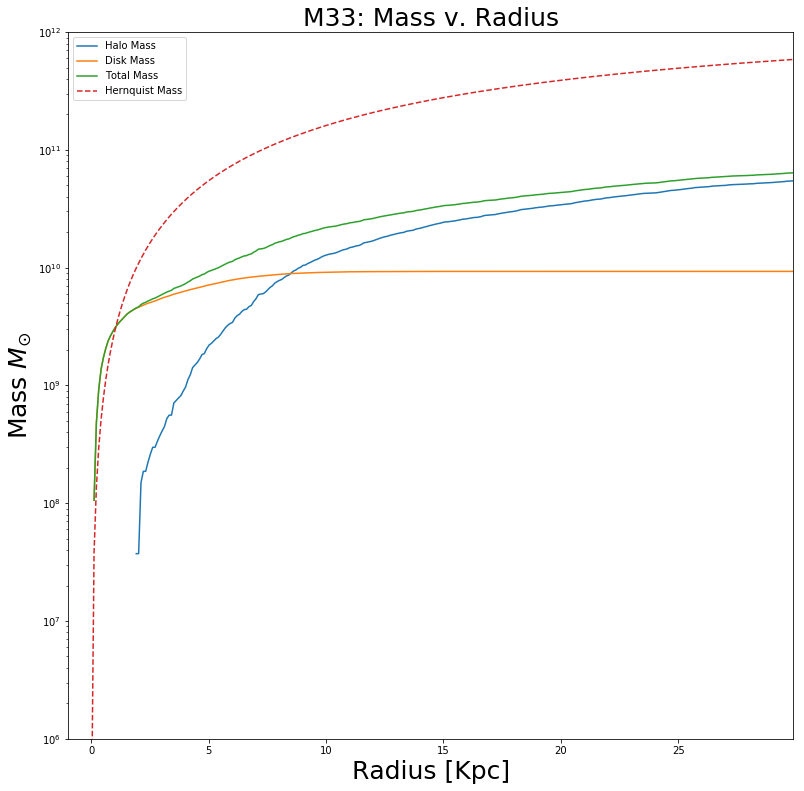

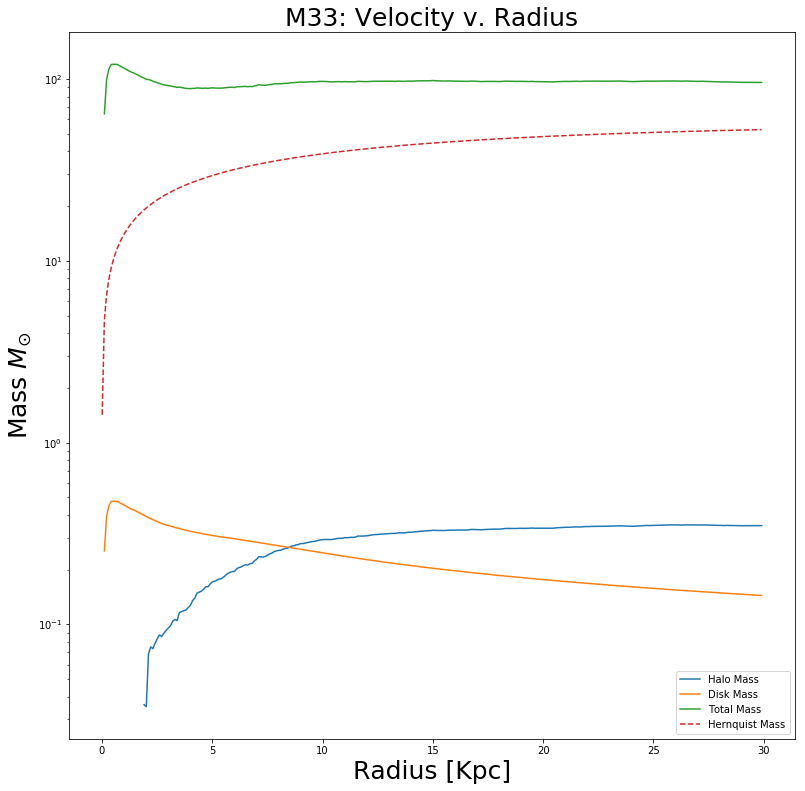

In [190]:
"""Plotting M33"""

plt.figure(figsize=([13,13]))
plt.title("M33: Mass v. Radius", fontsize = 25)
plt.xlabel("Radius [Kpc]", fontsize = 25)
plt.ylabel("Mass $M_{\odot}$", fontsize = 25)
plt.axis([-1,R_array[-1],1e6,1e12])
plt.semilogy(R_array, M33_M_Halo, '-', label = "Halo Mass")
plt.semilogy(R_array, M33_M_Disk, label = "Disk Mass")

plt.semilogy(R_array, M33_M_Total, label = "Total Mass")
plt.semilogy(R_array, M33_M_Hernq, '--', label = "Hernquist Mass")
#plt.semilogy(R_array, M33_M_Hernq1, '-.', label = "Hernquist Mass")
plt.legend()

plt.figure(figsize=([13,13]))
plt.title("M33: Velocity v. Radius", fontsize = 25)
plt.xlabel("Radius [Kpc]", fontsize = 25)
plt.ylabel("Mass $M_{\odot}$", fontsize = 25)
#plt.axis([-1,R_array[-1],1e6,1e12])
plt.semilogy(R_array, M33_V_Halo, '-', label = "Halo Mass")
plt.semilogy(R_array, M33_V_Disk, label = "Disk Mass")

plt.semilogy(R_array, M33_V_Total, label = "Total Mass")
plt.semilogy(R_array, M33_V_Hernq, '--', label = "Hernquist Mass")
#plt.semilogy(R_array, M33_M_Hernq1, '-.', label = "Hernquist Mass")
plt.legend()

In [ ]:
"""Velocity Profiles"""
